In [31]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
LLMmodel = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LLAMA2

In [111]:
#Prompt
prompt ="""<s>[INST] <<SYS>>
Interpret the following language instruction and provide the target object and target location. For example:
Language Instruction: "put the blue can into the green box". Target Object: {blue can}. Target Location: {green box}. 
<</SYS>>
put the brown blocks in a blue bowl. [/INST]"""

inputs = tokenizer(prompt, return_tensors="pt")

In [117]:
# Generate
generate_ids = LLMmodel.generate(inputs.input_ids, max_length=150)
response = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

In [108]:
# substract the key information from the response
answer = response.split("[/INST]")[1]
target_object = answer.split("Target Object: {")[1].split("}.")[0]
target_location = answer.split("Target Location: {")[1].split("}.")[0]
print("Target Object: ", target_object)
print("Target Location: ", target_location)


Target Object:  brown blocks
Target Location:  blue bowl


CLIPSeg

In [55]:
from PIL import Image
import requests
import numpy as np
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import torch
import matplotlib.pyplot as plt

In [56]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
Segmodel = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [107]:
num_img = 4
image = Image.open(f"CLIPSeg_imgs/cliport{num_img}.png")
image = np.asarray(image)[...,:3]
image.shape


(436, 542, 3)

In [109]:
prompts = [target_object, target_location]
inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")

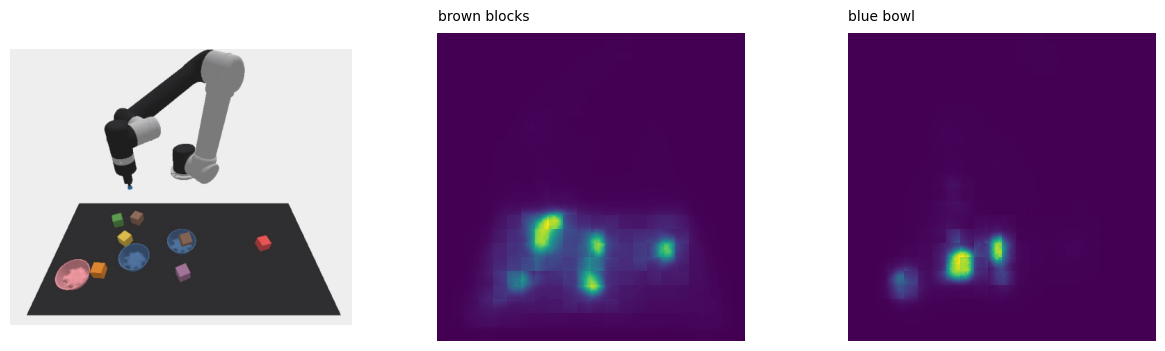

In [110]:
# predict
with torch.no_grad():
  outputs = Segmodel(**inputs)

preds = outputs.logits.unsqueeze(1)

# visualize prediction
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(2)];
[ax[i+1].text(0, -15, prompts[i]) for i in range(2)];
fig.savefig(f"./CLIPSeg_imgs/cliport{num_img}_result.png")

Convert to binary mask

idx:  (239, 139)


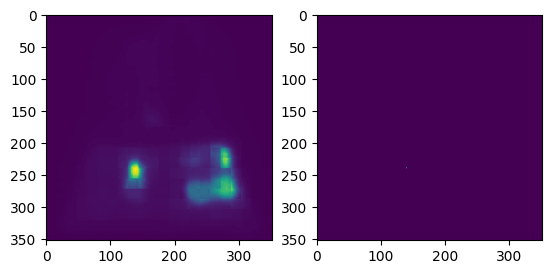

In [84]:
img1 = torch.sigmoid(preds[0][0]).numpy()
h , w = img1.shape
idx = np.argmax(img1)//h , np.argmax(img1)%h
print("idx: ", idx)
imgMax = np.zeros_like(img1)
imgMax[idx] = 1.
plt.subplot(1, 2, 1); plt.imshow(img1)
plt.subplot(1, 2, 2); plt.imshow(imgMax)


In [114]:
# apply a sigmoid activation function on the predicted mask
filename1 = f"mask1.png"
filename2 = f"mask2.png"
plt.imsave(filename1,torch.sigmoid(preds[0][0]))
plt.imsave(filename2,torch.sigmoid(preds[1][0]))

In [115]:
import cv2
img1 = cv2.imread(filename1)
img2 = cv2.imread(filename2)

Text(0.5, 1.0, 'blue bowl')

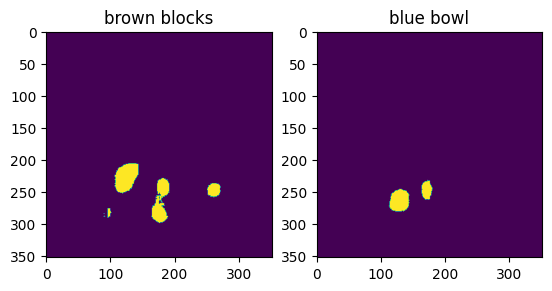

In [116]:
gray_image1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image1) = cv2.threshold(gray_image1, 100, 255, cv2.THRESH_BINARY)
(thresh, bw_image2) = cv2.threshold(gray_image2, 100, 255, cv2.THRESH_BINARY)

# fix color format
cv2.cvtColor(bw_image1, cv2.COLOR_BGR2RGB)
cv2.cvtColor(bw_image2, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image1)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(bw_image1)
ax[1].imshow(bw_image2)
ax[0].set_title(target_object)
ax[1].set_title(target_location)


